In [75]:
import pandas as pd
import numpy as np
#custom script to merge entries
import merging
import matplotlib.pyplot as plt
from datetime import datetime
import multiprocessing
from multiprocessing import Pool, cpu_count
import queue # imported for using queue.Empty exception
from datetime import date
from pathlib import Path  
from utils import plot_range_pie
from multiprocessing import Process, Lock
import gc, psutil
import glob

## Performing the grouping
Service RDT ID indicates the unique journey.
Stop:RDT ID Indicates the unique stop.

We need to merge the entries to form journeys - where the train was going to and from.

### Dataset observations:

- Most of null occurencies in arrival date (324k == 99%) are on first stop
- However there are 169 cases where it's not a first, but some other stop
- Let's analyze the delays - will keeping those entries be valuable? Perhaps they are an important piece of data?

In [51]:
dataset_pre = pd.read_csv('preprocessed_data/basic_preprocessed_light.csv')

In [52]:
len(dataset_pre)

13613841

In [53]:
dataset_pre.loc[dataset_pre["Stop:Arrival cancelled"] == True, "Stop:Arrival delay"] = 1000
dataset_pre.loc[dataset_pre["Stop:Departure cancelled"] == True, "Stop:Departure delay"] = 1000

In [54]:
dataset_pre.head(10)

,Service:RDT-ID,Service:Type,Service:Completely cancelled,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Number,Technical:Max-Stop-Num
0,12690865,Intercity,False,RTD,Rotterdam Centraal,NaN,0.0,False,2024-01-01T02:00:00+01:00,0.0,False,False,1,9
1,12690865,Intercity,False,DT,Delft,2024-01-01T02:13:00+01:00,0.0,False,2024-01-01T02:13:00+01:00,0.0,False,False,2,9
2,12690865,Intercity,False,GV,Den Haag HS,2024-01-01T02:21:00+01:00,0.0,False,2024-01-01T02:22:00+01:00,0.0,False,False,3,9
3,12690865,Intercity,False,LEDN,Leiden Centraal,2024-01-01T02:35:00+01:00,0.0,False,2024-01-01T02:40:00+01:00,0.0,False,True,4,9
4,12690865,Intercity,False,SHL,Schiphol Airport,2024-01-01T03:00:00+01:00,0.0,False,2024-01-01T03:03:00+01:00,0.0,False,False,5,9
5,12690865,Intercity,False,ASS,Amsterdam Sloterdijk,2024-01-01T03:12:00+01:00,0.0,False,2024-01-01T03:12:00+01:00,0.0,False,False,6,9
6,12690865,Intercity,False,ASD,Amsterdam Centraal,2024-01-01T03:18:00+01:00,1.0,False,2024-01-01T03:20:00+01:00,2.0,False,False,7,9
7,12690865,Intercity,False,ASB,Amsterdam Bijlmer ArenA,2024-01-01T03:31:00+01:00,2.0,False,2024-01-01T03:31:00+01:00,2.0,False,False,8,9
8,12690865,Intercity,False,UT,Utrecht Centraal,2024-01-01T03:50:00+01:00,0.0,False,NaN,0.0,False,False,9,9
9,12690867,Intercity,False,UT,Utrecht Centraal,NaN,0.0,False,2024-01-01T02:16:00+01:00,0.0,False,False,1,9


In [55]:
dataset_pre = dataset_pre[dataset_pre["Technical:Max-Stop-Num"] > 1]


In [56]:
null_not_on_arrival = dataset_pre[(dataset_pre['Stop:Arrival time'].isna()) & (dataset_pre['Stop:Number'] != 1)]
null_not_on_arrival.head()

check_2 = dataset_pre[(dataset_pre['Stop:Departure time'].isna()) & (dataset_pre['Stop:Number'] != dataset_pre["Technical:Max-Stop-Num"])]
len(check_2)

5777

In [57]:
delay = dataset_pre[dataset_pre["Stop:Arrival delay"] == 1000]
print(len(delay))

597450


In [58]:
test_ranges_1 = [(0,0), (1, 2), (3, 5), (6, 10), (11, 20), (21, 40), (41, 180), (180, 1001)]

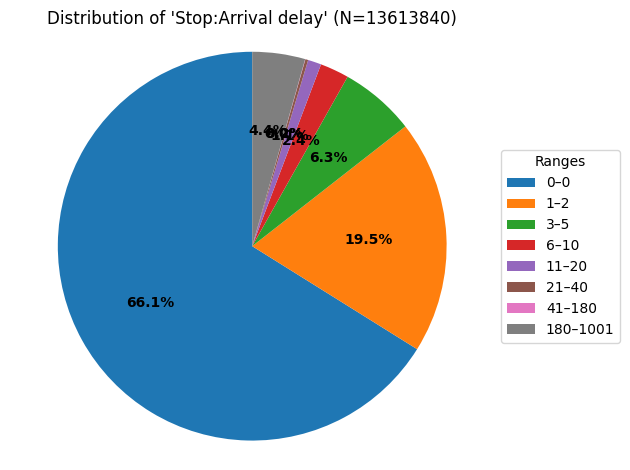

0–0 - 66.1%, 9000394
1–2 - 19.5%, 2647999
3–5 - 6.3%, 854236
6–10 - 2.4%, 327280
11–20 - 1.1%, 151392
21–40 - 0.2%, 32026
41–180 - 0.0%, 3042
180–1001 - 4.4%, 597464


['0–0 - 66.1%, 9000394',
 '1–2 - 19.5%, 2647999',
 '3–5 - 6.3%, 854236',
 '6–10 - 2.4%, 327280',
 '11–20 - 1.1%, 151392',
 '21–40 - 0.2%, 32026',
 '41–180 - 0.0%, 3042',
 '180–1001 - 4.4%, 597464']

In [59]:
#Plotting departure delays, normal dataset
plot_range_pie(dataset_pre, "Stop:Arrival delay", test_ranges_1)

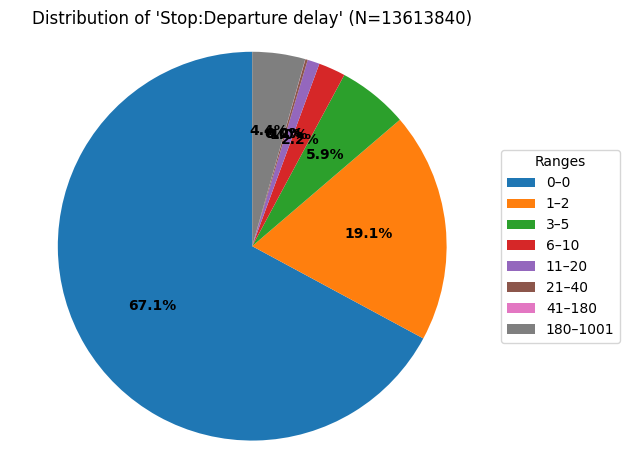

0–0 - 67.1%, 9138530
1–2 - 19.1%, 2606056
3–5 - 5.9%, 799950
6–10 - 2.2%, 304935
11–20 - 1.0%, 136861
21–40 - 0.2%, 26666
41–180 - 0.0%, 2267
180–1001 - 4.4%, 598568


['0–0 - 67.1%, 9138530',
 '1–2 - 19.1%, 2606056',
 '3–5 - 5.9%, 799950',
 '6–10 - 2.2%, 304935',
 '11–20 - 1.0%, 136861',
 '21–40 - 0.2%, 26666',
 '41–180 - 0.0%, 2267',
 '180–1001 - 4.4%, 598568']

In [60]:
#Plotting departure delays, normal dataset
plot_range_pie(dataset_pre, "Stop:Departure delay", test_ranges_1)

## Judging by the dataset:
- Stop id increments as the journey progresses
- First stop has arrival time as NaN
- Final stop has departure time as NaN

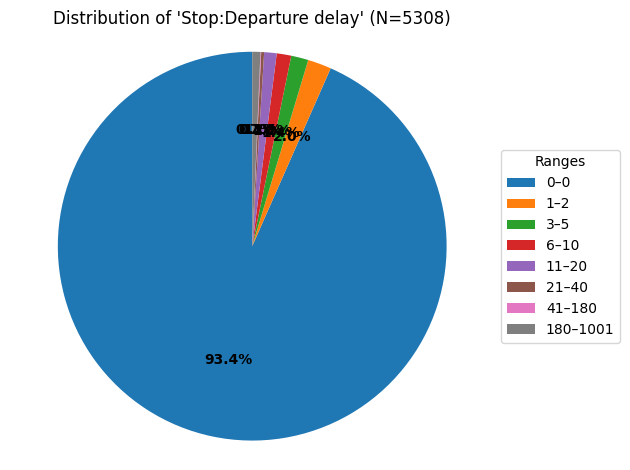

0–0 - 93.4%, 4957
1–2 - 2.0%, 104
3–5 - 1.4%, 76
6–10 - 1.2%, 64
11–20 - 1.0%, 55
21–40 - 0.2%, 13
41–180 - 0.1%, 3
180–1001 - 0.7%, 36


['0–0 - 93.4%, 4957',
 '1–2 - 2.0%, 104',
 '3–5 - 1.4%, 76',
 '6–10 - 1.2%, 64',
 '11–20 - 1.0%, 55',
 '21–40 - 0.2%, 13',
 '41–180 - 0.1%, 3',
 '180–1001 - 0.7%, 36']

In [61]:
#Plotting departure delays, normal dataset
plot_range_pie(null_not_on_arrival, "Stop:Departure delay", test_ranges_1)


In [62]:
# Step 1: Identify bad RDT-IDs based on either condition
ids_to_drop = dataset_pre.loc[
    ((dataset_pre['Stop:Arrival time'].isna()) & (dataset_pre['Stop:Number'] != 1)) |
    ((dataset_pre['Stop:Departure time'].isna()) & (dataset_pre['Stop:Number'] != dataset_pre["Technical:Max-Stop-Num"])),
    'Service:RDT-ID'
].unique()

# Step 2: Drop all rows with those RDT-IDs
dataset_pre = dataset_pre[~dataset_pre['Service:RDT-ID'].isin(ids_to_drop)]


In [63]:
def column_null_overview(df: pd.DataFrame):
    null_counts = (df.isna() | df.eq('')).sum()   # vectorised, very fast
    overview = null_counts.to_dict()
    print(overview)
    return overview

In [64]:
check_3 = dataset_pre[(dataset_pre['Stop:Departure time'].notna()) & (dataset_pre['Stop:Number'] == dataset_pre["Technical:Max-Stop-Num"])]
len(check_3)
len(dataset_pre)

13561474

In [65]:

ids_to_drop = dataset_pre.loc[
    (dataset_pre['Stop:Departure time'].notna()) &
    (dataset_pre['Stop:Number'] == dataset_pre["Technical:Max-Stop-Num"]),
    'Service:RDT-ID'
].unique()

# Step 2: Drop all rows with those Service:RDT-ID values
dataset_pre = dataset_pre[~dataset_pre['Service:RDT-ID'].isin(ids_to_drop)]

In [66]:
ids_to_drop = dataset_pre.loc[
    (dataset_pre['Stop:Departure time'].notna()) &
    (dataset_pre['Stop:Number'] == dataset_pre["Technical:Max-Stop-Num"]),
    'Service:RDT-ID'
].unique()

In [67]:
column_null_overview(dataset_pre)

{'Service:RDT-ID': 0, 'Service:Type': 0, 'Service:Completely cancelled': 0, 'Stop:Station code': 0, 'Stop:Station name': 0, 'Stop:Arrival time': 1259760, 'Stop:Arrival delay': 0, 'Stop:Arrival cancelled': 0, 'Stop:Departure time': 1259762, 'Stop:Departure delay': 0, 'Stop:Departure cancelled': 0, 'Stop:Platform change': 0, 'Stop:Number': 0, 'Technical:Max-Stop-Num': 0}


{'Service:RDT-ID': 0,
 'Service:Type': 0,
 'Service:Completely cancelled': 0,
 'Stop:Station code': 0,
 'Stop:Station name': 0,
 'Stop:Arrival time': 1259760,
 'Stop:Arrival delay': 0,
 'Stop:Arrival cancelled': 0,
 'Stop:Departure time': 1259762,
 'Stop:Departure delay': 0,
 'Stop:Departure cancelled': 0,
 'Stop:Platform change': 0,
 'Stop:Number': 0,
 'Technical:Max-Stop-Num': 0}

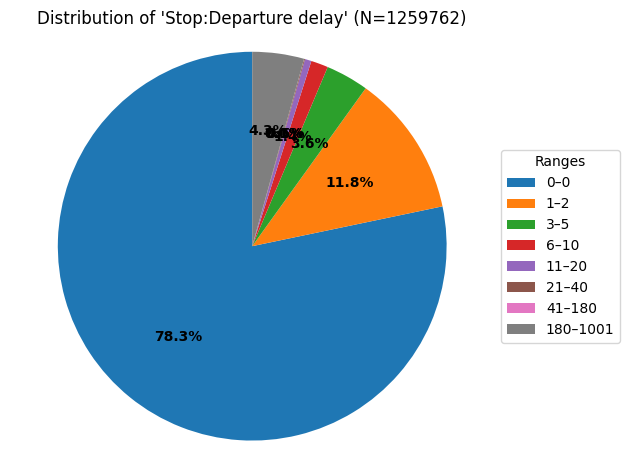

0–0 - 78.3%, 986195
1–2 - 11.8%, 148609
3–5 - 3.6%, 45007
6–10 - 1.4%, 17948
11–20 - 0.5%, 6818
21–40 - 0.1%, 951
41–180 - 0.0%, 65
180–1001 - 4.3%, 54166


['0–0 - 78.3%, 986195',
 '1–2 - 11.8%, 148609',
 '3–5 - 3.6%, 45007',
 '6–10 - 1.4%, 17948',
 '11–20 - 0.5%, 6818',
 '21–40 - 0.1%, 951',
 '41–180 - 0.0%, 65',
 '180–1001 - 4.3%, 54166']

In [68]:
first_stops = dataset_pre[dataset_pre['Stop:Number'] == 1]
last_stops = dataset_pre[dataset_pre['Stop:Number'] == dataset_pre["Technical:Max-Stop-Num"]]
plot_range_pie(first_stops, "Stop:Departure delay", test_ranges_1)

In [69]:
len(dataset_pre)

13561474

In [70]:
CHUNK = 2_000_000
n_chunks = -(-len(dataset_pre) // CHUNK)

def process_chunk(df_chunk, idx):
    """Run your existing group-merge logic on one slice."""
    grouped = df_chunk.groupby('Service:RDT-ID')
    args = [(jid, grp) for jid, grp in grouped]

    with Pool(cpu_count() - 1) as pool:
        out = pool.map(merging.merge_func, args)

    # write to disk immediately, then drop from RAM
    pd.concat(out).to_parquet(f"post_part_{idx}.parquet")
    del out, args, grouped, df_chunk
    gc.collect()

for i in range(n_chunks):
    start = i * CHUNK
    end   = start + CHUNK
    slice_df = dataset_pre.iloc[start:end]
    process_chunk(slice_df, i)

In [76]:
import pyarrow.dataset as ds

files = glob.glob("post_part_*.parquet")
dataset = ds.dataset(files)
dataset_post = dataset.to_table().to_pandas()

In [77]:
dataset_post.head()

,Journey id,Train type,Departure station code,Arrival station code,Departure station name,Arrival station name,Departure time,Arrival time,Departure delay,Arrival delay,Part number,Cancelled,Departure platform changed,Arrival platform changed
0,12690865,Intercity,RTD,DT,Rotterdam Centraal,Delft,2024-01-01T02:00:00+01:00,2024-01-01T02:13:00+01:00,0.0,0.0,1,False,False,False
1,12690865,Intercity,DT,GV,Delft,Den Haag HS,2024-01-01T02:13:00+01:00,2024-01-01T02:21:00+01:00,0.0,0.0,2,False,False,False
2,12690865,Intercity,GV,LEDN,Den Haag HS,Leiden Centraal,2024-01-01T02:22:00+01:00,2024-01-01T02:35:00+01:00,0.0,0.0,3,False,False,True
3,12690865,Intercity,LEDN,SHL,Leiden Centraal,Schiphol Airport,2024-01-01T02:40:00+01:00,2024-01-01T03:00:00+01:00,0.0,0.0,4,False,True,False
4,12690865,Intercity,SHL,ASS,Schiphol Airport,Amsterdam Sloterdijk,2024-01-01T03:03:00+01:00,2024-01-01T03:12:00+01:00,0.0,0.0,5,False,False,False


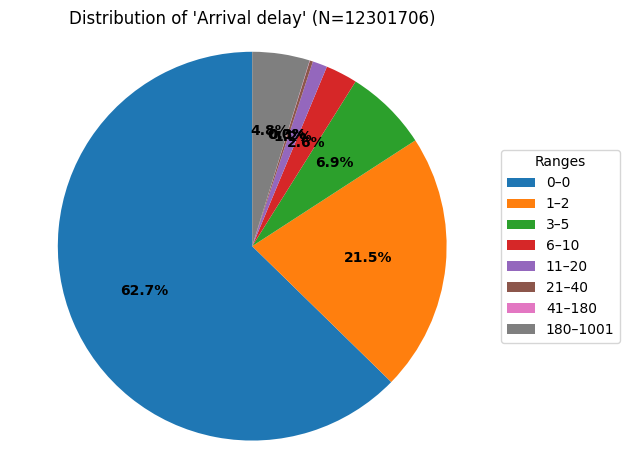

0–0 - 62.7%, 7710983
1–2 - 21.5%, 2641763
3–5 - 6.9%, 851273
6–10 - 2.6%, 325666
11–20 - 1.2%, 150316
21–40 - 0.3%, 31549
41–180 - 0.0%, 2951
180–1001 - 4.8%, 587198


['0–0 - 62.7%, 7710983',
 '1–2 - 21.5%, 2641763',
 '3–5 - 6.9%, 851273',
 '6–10 - 2.6%, 325666',
 '11–20 - 1.2%, 150316',
 '21–40 - 0.3%, 31549',
 '41–180 - 0.0%, 2951',
 '180–1001 - 4.8%, 587198']

In [78]:
plot_range_pie(dataset_post, "Arrival delay", test_ranges_1)

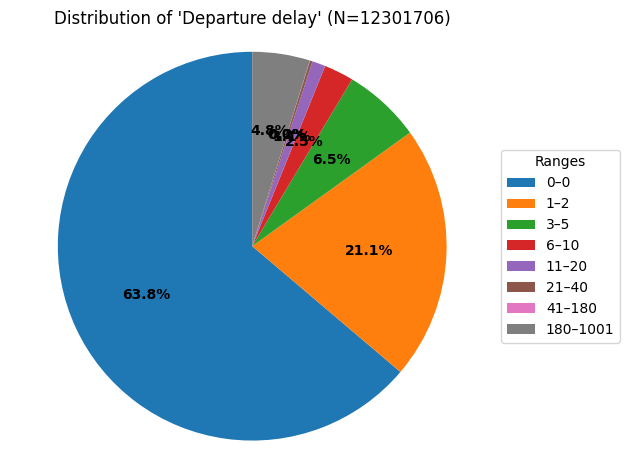

0–0 - 63.8%, 7848258
1–2 - 21.1%, 2599422
3–5 - 6.5%, 797228
6–10 - 2.5%, 303480
11–20 - 1.1%, 135948
21–40 - 0.2%, 26416
41–180 - 0.0%, 2236
180–1001 - 4.8%, 588711


['0–0 - 63.8%, 7848258',
 '1–2 - 21.1%, 2599422',
 '3–5 - 6.5%, 797228',
 '6–10 - 2.5%, 303480',
 '11–20 - 1.1%, 135948',
 '21–40 - 0.2%, 26416',
 '41–180 - 0.0%, 2236',
 '180–1001 - 4.8%, 588711']

In [79]:
plot_range_pie(dataset_post, "Departure delay", test_ranges_1)

In [80]:
dataset_post.to_csv('preprocessed_data/merged_journeys.csv', index=False)